In [61]:
from skimage import io,color,filters
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ipywidgets import AppLayout, FloatSlider
import ipywidgets as widgets



Asumir gaps pequeños

Pesos variables ~ Nº de puntos en ventana, si hay mucho distancia > densidad > value > sentido


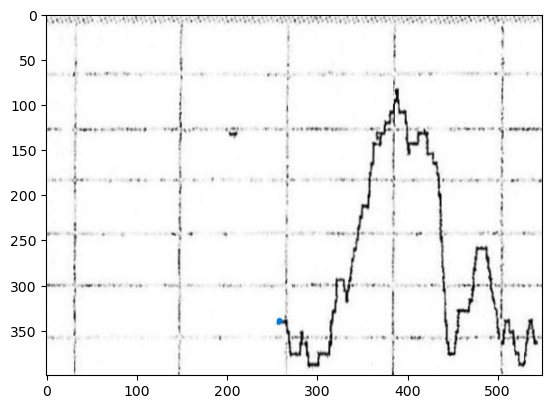

In [2]:
A=io.imread('./final_1_pointed.jpeg')
A=A[700:1100,:550]
plt.imshow(A)
A_hsv=color.rgb2hsv(A)

In [3]:
def B_hsv(X):
    t1=X[0]>=168/360
    t2=X[0]<=263/360
    t3=X[1]>=0.75
    t4=X[2]>=0.4
    
    return t1 and t2 and t3 and t4
def black_hsv(x):
    t1=x[2]<=0.15
    t2=x[1]<=0.25
    t3=x[2]<=0.7
    
    return t1 or (t2 and t3)

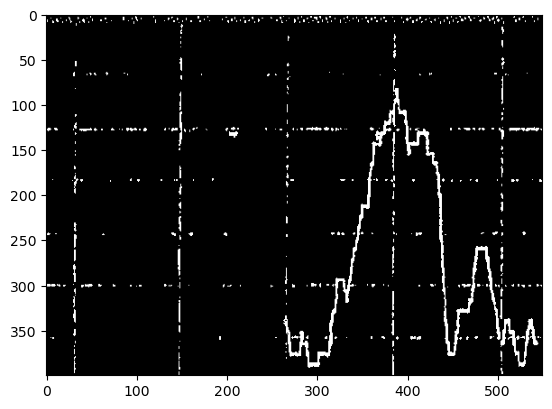

In [4]:
A_bin=np.apply_along_axis(black_hsv,-1,A_hsv)
plt.imshow(A_bin,cmap='gray')

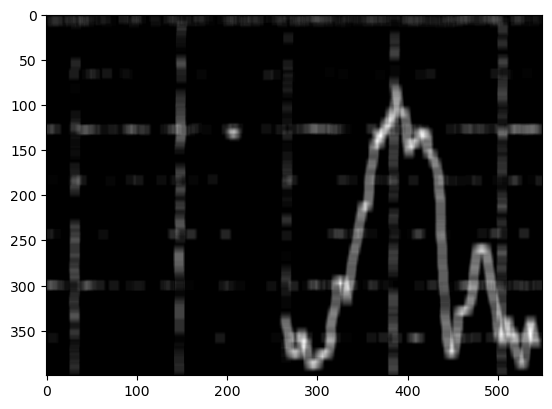

In [5]:
def countpoint(x,y,kernel=3):
    M,m=A_bin.shape
    lx=ly=kernel//2 
    rx=ry=kernel//2 +1
    if x-lx <0:
        lx=x
    if y-ly <0:
        ly=y
    if x+rx >M:
        rx=M-x
    if y+ry >m:
        ry=m-y
        
    w=A_bin[x-lx:x+rx,y-ly:y+ry]
    return np.sum(w)

D=np.zeros(A_bin.shape,int)
for i in range(A_bin.shape[0]):
    for j in range(A_bin.shape[1]):
        D[i,j]=countpoint(i,j,kernel=10)

plt.imshow(D,cmap='gray')        

In [65]:
def dist(x:int,window:tuple,dot:tuple):
    t=[x//window[1],x%window[1]]
    max_dist=((window[0]-dot[0])**2+(window[1]-dot[1])**2)**0.5
    return ((t[0]-dot[0])**2+(t[1]-dot[1])**2)**0.5

def S(x:int,window:tuple,dot:tuple):
    t=[x//window[1],x%window[1]]
   
    return np.sign(t[1]-dot[1])

def topsis(df,casos,pesos):
    casos/=np.sum(df**2)
    df/=np.sum(df**2)
    df*=pesos
    casos*=pesos
    dp=np.sum((df-casos.loc[0])**2,axis=1)
    dn=np.sum((df-casos.loc[1])**2,axis=1)
    df['R']=dn/(dn+dp)
    df.sort_values('R',ascending=False,inplace=True)
    
    return df

def next_point(li,pointer,dot,PASSED):
    try:
        r=next(li)
        p=[pointer[0]+(r[0]-dot[0]),pointer[1]+(r[1]-dot[1])]
        while p in PASSED:
            r=next(li)
            p=[pointer[0]+(r[0]-dot[0]),pointer[1]+(r[1]-dot[1])]
            
    except StopIteration:
        print('No hay mas')
    finally:
        #print(f'{pointer} to {p}')
        return p
        
        
        

In [71]:
# precomputing all images
x = np.linspace(0,np.pi,200)
y = np.linspace(0,10,200)
X,Y = np.meshgrid(x,y)
parameter = np.linspace(-5,5)
example_image_stack = np.sin(X)[None,:,:]+np.exp(np.cos(Y[None,:,:]*parameter[:,None,None]))
with plt.ioff():
    fig = plt.figure()
im = plt.imshow(example_image_stack[0])

def update(change):
    im.set_data(example_image_stack[change['new']])
    fig.canvas.draw_idle()
    
    
slider = widgets.IntSlider(value=0, min=0, max=len(parameter)-1)
slider.observe(update, names='value')
widgets.VBox([slider, fig.canvas])

In [73]:


#Starting Point
mask=np.apply_along_axis(B_hsv,-1,A_hsv)
x,y=np.where(mask)
center=[(max(x)+min(x))//2,(max(y)+min(y))//2]
R=list()


def pathing(A_hsv,center,kernel=51,pesos=[1/4,1/4,1/4,1/4],max_it=300):
    
    if not kernel%2:
        kernel+=1
    
    #IMG to path
    STACKED=[]
    PATH=A_hsv.copy().astype('uint8')
    PATH[:,:]=[255,255,255]
    PATH[center[0],center[1]]=[255,0,0]
    pointer=center
    PASSED=[center]
    it=0
    STACKED.append(PATH)
    W=np.zeros((max_it,len(pesos)))
    
    while it<max_it:
        
        #Ventana
        radio=kernel//2
        x1=pointer[0]-radio
        x2=pointer[0]+radio
        y1=pointer[1]+radio
        y2=pointer[1]-radio
        dot=[radio,radio]
        
        if x1<0:
            x1=0
            dot[0]=pointer[0]
        if y1<0:
            y1=0
            dot[1]=pointer[1]
        
        window=A_hsv[pointer[0]-kernel//2:pointer[0]+kernel//2,pointer[1]-kernel//2:pointer[1]+kernel//2].copy()
        dd=D[pointer[0]-kernel//2:pointer[0]+kernel//2,pointer[1]-kernel//2:pointer[1]+kernel//2] #Densidad
        dd=dd.reshape(dd.shape[0]*dd.shape[1],1)
        
        
        rw=window.reshape(window.shape[0]*window.shape[1],3)
        rw=pd.DataFrame(rw)
        rw=rw[rw.apply(black_hsv,axis=1)] #Filtro de Negros
        dd=dd[rw.index]
        pesos=Pesos_Var(np.sum(dd))
        W[it]=pesos
        R.append(np.sum(dd))
        #Preparado de topsis
        df=pd.DataFrame([])
        df['Value']=rw.loc[:,2]
        df['Dist']=[dist(i,window.shape,dot) for i in df.index]
        df['Points']=dd
        df['Sentido']=[S(i,window.shape,dot) for i in df.index]
        
        max_dist_point=(np.array(dot) < np.array(window.shape[0:2])/2)*window.shape[0:2] #Esquina más lejana
        max_dist=((max_dist_point[0]-dot[0])**2+(max_dist_point[1]-dot[1])**2)**0.5      #Distancia a la esquina
    
        casos=pd.DataFrame([[0,0,np.max(df['Points']),1],[1,max_dist,0,-1]],columns=['Value','Dist','Points','Sentido'])
        
        df=topsis(df,casos,pesos)
        li=map(lambda x: [x//window.shape[1],x%window.shape[1]],df.index)
        p=next_point(li,pointer,dot,PASSED)
        # print(f'window {window.shape[0]}x{window.shape[1]} with dot in {dot}\nWeights:{pesos}')
        # print(df.head(3))
        
        #Asignación de nuevo centro
        pointer=p
        P=STACKED[it].copy()
        P[pointer[0],pointer[1]]=[255,0,0]
        PASSED.append(pointer)
        STACKED.append(P)
        
        
        it+=1

    

    
    return STACKED,W
    
    



Hay un problema y es que si se le permite ir para atrás rellena huecos pero se queda atascado.
Sumar peso al sentido

In [8]:
#1
def rect(x,V,v,m=6000,M=25000):
    a=(v-V)/(M-m)
    b=V-a*m
    return a*x+b

#2
def rect(x,V,v,m=7500,M=30000):
    if x<m:
        x=m
    elif x>M:
        x=M
    a=(v-V)/(M-m)
    b=V-a*m
    return a*x+b


#3
def rect(x,V,v,m=6000,M=25000):
    a=(V-v)/(m*(m-M))
    b=-a*M
    return a*x**2+b*x+v

#4
def rect(x,V,v,m=6000,M=25000):
    a=(v-V)/(M-m)
    b=V-a*m
    return a*x+b



In [9]:
def Pesos_Var(x):
    return [rect(x,0.3,0.01),
           rect(x,0.325,0.94),
           rect(x,0.325,0.049),
           rect(x,0.05,0.001)]

In [74]:
import matplotlib.pyplot as plt
R=list()
P,W=pathing(A_hsv,center,pesos=[0.2,0.5,0.25,0.05],max_it=500)

In [75]:
with plt.ioff():
        fig = plt.figure()
im = plt.imshow(P[0])

def update(change):
    im.set_data(P[change['new']])
    fig.canvas.draw_idle()
    
    
slider = widgets.IntSlider(value=0, min=0, max=len(P))
slider.observe(update, names='value')
widgets.VBox([slider, fig.canvas])

In [252]:
w=pd.DataFrame(W,columns=['Value','Distancia','Densidad','Sentido'])
b=pd.DataFrame(P[1:])
b=pd.concat([w,b],axis=1)
b['R']=R
b.sort_values(1,inplace=True)
b.reset_index(drop=True,inplace=True)

(0.0, 550.0)

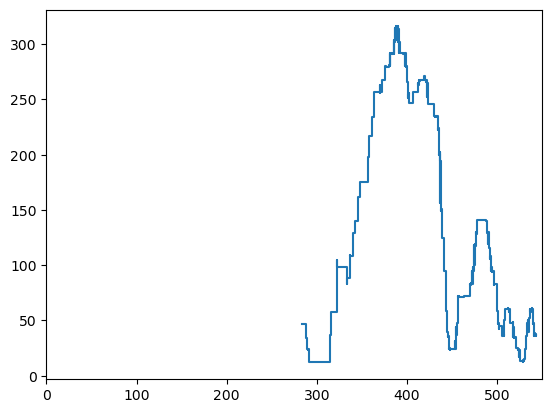

In [253]:
#plt.plot(b['R'])
plt.step(b[1],400-b[0],where='post')
plt.xlim(0,550)

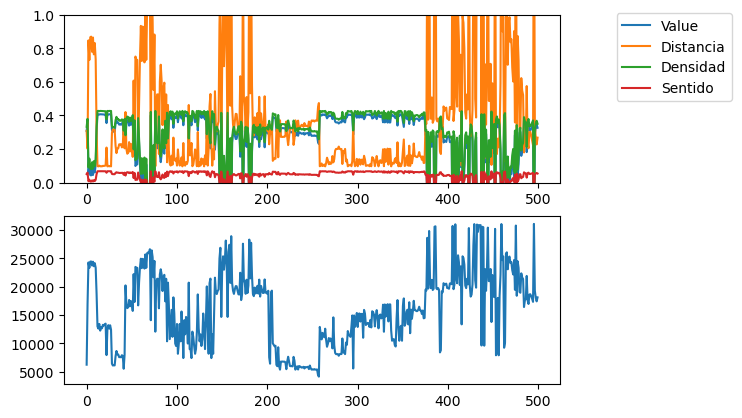

In [254]:
fig,ax=plt.subplots(2,1)
ax[0].plot(b[['Value','Distancia','Densidad','Sentido']])
ax[0].set_ylim(0,1)
ax[0].legend(['Value','Distancia','Densidad','Sentido'],bbox_to_anchor=(1.1, 1.05))
ax[1].plot(b['R'])